In [1]:
import pandas as pd
import os
from os.path import join
import seaborn as sns
import numpy as np
from coevolve import read_msa
from coevolve.visualization.fig_utils import *
from collections import defaultdict
import matplotlib

## Load env variable

In [2]:
from config import RESULTS, FIGURES_DIR
print(RESULTS)
print(FIGURES_DIR)

Project Directory: /data2/isshamie/covid

Config paths:
__name__ config
__package__ 
__file__ /data2/isshamie/covid/notebook/config.py
__cached__ /data2/isshamie/covid/notebook/__pycache__/config.cpython-37.pyc
path /data2/isshamie/covid/notebook/config.py
DATA_DIR /data2/isshamie/covid/data
RESULTS /data2/isshamie/covid/data/processed
FIGURES_DIR /data2/isshamie/covid/figures
FIG_NET_DIR /data2/isshamie/covid/figures/networks
PIPELINE_F /data2/isshamie/covid/reports/pipeline/Pipeline.xlsx
DATA_FIG_DIR /data2/isshamie/covid/data/processed/figures
PARAMS_DIR /data2/isshamie/covid/parameters
TEST_DIR /data2/isshamie/covid/tests
d /data2/isshamie/covid/tests
UNIPROT_MAP /data2/isshamie/covid/data/external/biomart/mart_export_uniprot.txt
GENE_MAP /data2/isshamie/covid/data/external/biomart/mart_export.txt
SECM_ANNO /data2/isshamie/covid/data/external/secretory_annotations/SM_feizi.tsv
SECP_ANNO /data2/isshamie/covid/data/external/secretory_annotations/SP_feizi.tsv
NETWORKS_DIR /data/issham

In [24]:
evc_dir = join(RESULTS,"evc")
col90_red_8_dir = join(evc_dir, "col90_redund0.8")
align_dir = join(col90_red_8_dir,"align")
coupling_dir = join(col90_red_8_dir,"coupling")
contact_dir = join(RESULTS, "contact")
if not os.path.exists(contact_dir):
    os.mkdir(contact_dir)

gene_of_interest = "col90_redund0.8"
align_prefix = os.path.join(evc_dir,gene_of_interest,"align",gene_of_interest)
coupling_prefix = os.path.join(evc_dir, gene_of_interest,"couplings",gene_of_interest)

print(coupling_prefix)
print(align_prefix)

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/couplings/col90_redund0.8
/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8


------

## Part 1: Alignment statistics

For the monomer pipeline, the alignment is found in the align subdirectory of the output folder. For the complexes pipeline, the concatenated alignment is found in the concatenate subdirectory, and the individual monomer alignments are found in the align_1 and align_2 subdirectories. 

### Final alignment file (.a2m)

The final alignment file in [.a2m format](https://compbio.soe.ucsc.edu/a2m-desc.html). This file is used to calculate evolutionary couplings (ECs). Lowercase columns indicate columns with too many gaps that did not meet the minimum column coverage threshold, which means they were excluded from the EC calculation. Lowercase columns have a '.' for gap character by convention. Additionally, sequences which did not fulfill the the minimum sequence coverage threshold (i.e. fragments with too many gaps) have been removed from this alignment. 

*output key: alignment_file*

In [4]:
from evcouplings.align import Alignment

# Load the alignment - format will be detected automatically but can also be set manually
with open(align_prefix +  ".a2m") as f:
    aln = Alignment.from_file(f)

print("Alignment has {} sequences and {} columns".format(aln.N, aln.L))

Alignment has 532 sequences and 1273 columns


### Alignment and EC statistics summary (_job_statistics_summary.csv)

Contains information on properties of the final alignment. This file is only produced if the *evcouplings* application is run (otherwise see alignment_statistics.csv for a truncated version of this file, *output key: statistics_file*).

Columns:
   - prefix: run prefix
   - minimum_column_coverage: user input, fraction of non-gap characters required per column
   - num_seqs: number of sequences in final alignment
   - seqlen: length of target sequence (interchangeably called the query sequence)
   - num_cov: number of uppercase columns in final alignment (columns that satisfied minimumum_column_coverage) 
   - num_lc: number of lowercase columns in final alignment (columns that did not satisfy minimum_column_coverage)
   - perc_cov: fraction of columns that are uppercase (num_cov / seqlen)
   - 1st_uc: index of first uppercase column, numbered according to target sequence
   - last_uc: index of last uppercase column, numbered according to target sequence
   - len_cov: last_uc - 1st_uc
   - num_lc_cov: number of lowercase columns between 1st_uc and last_uc (i.e. num_cov = len_cov - num_lc_cov)
   - N_eff: effective number of non-redundant sequences after clustering based on theta parameter(similar neighborhood = 1 sequence)
   - domain_threshold: sequence search inclusion threshold
   - average_identity: average percent identity of sequences in the alignments to the target sequence
   
The following outputs are only added if the "couplings" and "compare" stages of the pipeline are also run, respectively:
   - num_significant: number of significant ECs (at 90% probabilitity cutoff)
   - precision: precision of the top L significant ECs compared to structure

In [5]:
pd.read_csv(align_prefix+"_alignment_statistics.csv").transpose()

,0
prefix,../data/processed/evc/col90_redund0.8/align/co...
minimum_column_coverage,0.9
num_seqs,532
seqlen,1273
num_cov,1273
num_lc,0
perc_cov,1
1st_uc,1
last_uc,1273
len_cov,1273


### Frequencies file (_frequencies.csv)


Contains the frequency of each character in each position of the alignment. These frequencies are raw, i.e. does not sequence reweighting.

*output key: frequencies_file*

Columns: 
- pos: position in alignment, numbered according to target sequence
- target_seq: character in target sequence
- conservation: column entropy. A value of 1 indicates perfect conservation. A value near zero indicates very little conservation.
- [chars]: the remaining columns are frequency of each character in that position in the alignment


In [6]:
frequencies = pd.read_csv(align_prefix + "_frequencies.csv")
conserved_sequence = frequencies["A_i"].values
frequencies.head()

,i,A_i,conservation,-,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,1,M,0.957,0.0,0.0,0.002,0.0,0.0,0.002,0.0,...,0.979,0.004,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.009
1,2,F,0.973,0.0,0.0,0.000,0.0,0.0,0.985,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.013,0.0,0.000
2,3,V,0.960,0.0,0.0,0.013,0.0,0.0,0.004,0.0,...,0.000,0.000,0.0,0.0,0.0,0.002,0.000,0.979,0.0,0.000
3,4,F,0.987,0.0,0.0,0.000,0.0,0.0,0.994,0.0,...,0.000,0.000,0.0,0.0,0.0,0.002,0.000,0.000,0.0,0.000
4,5,L,0.961,0.0,0.0,0.000,0.0,0.0,0.006,0.0,...,0.000,0.000,0.0,0.0,0.0,0.013,0.002,0.000,0.0,0.000


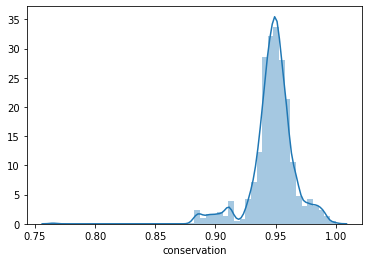

In [7]:
sns.distplot(frequencies["conservation"])

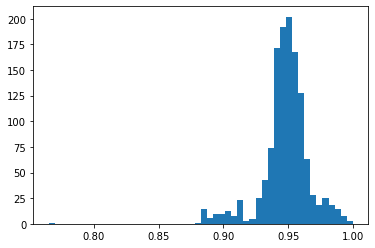

In [30]:
plt.hist(frequencies["conservation"], bins=50)
plt.savefig(join(FIGURES_DIR, "conservation_histogram.png"))
plt.savefig(join(FIGURES_DIR, "conservation_histogram.svg"))

In [37]:
sliding = 10
bin_size = 20
conservation_smooth = []
for i in range(0,frequencies.shape[0], sliding):
    conservation_smooth.append(frequencies["conservation"][i:i+bin_size].mean())
    
conservation_smooth

[0.9660000000000002,
 0.9614999999999998,
 0.9573,
 0.9544500000000001,
 0.9573999999999998,
 0.9618999999999998,
 0.9604999999999999,
 0.9593,
 0.9611000000000001,
 0.96455,
 0.9625,
 0.9601499999999998,
 0.96365,
 0.9605500000000001,
 0.9496500000000001,
 0.9481000000000002,
 0.95055,
 0.9472500000000001,
 0.9383499999999998,
 0.9323499999999999,
 0.9413499999999999,
 0.9473,
 0.9483,
 0.9492499999999999,
 0.9471,
 0.9440499999999998,
 0.9445,
 0.9441999999999998,
 0.9406500000000001,
 0.9447500000000002,
 0.94615,
 0.94115,
 0.9427999999999999,
 0.9455,
 0.9458,
 0.9441499999999999,
 0.9423500000000002,
 0.9432500000000001,
 0.9451,
 0.9468,
 0.9474499999999999,
 0.9517000000000001,
 0.94235,
 0.91325,
 0.9036,
 0.9103000000000001,
 0.9042499999999999,
 0.9005000000000001,
 0.89985,
 0.8983000000000001,
 0.90055,
 0.908,
 0.9342499999999999,
 0.95855,
 0.9594499999999998,
 0.9574499999999999,
 0.95845,
 0.9606000000000003,
 0.9609500000000001,
 0.9588000000000001,
 0.949900000000000

Text(0.5, 1.0, 'Conservatin over every 20 amino acids with sliding window of 10')

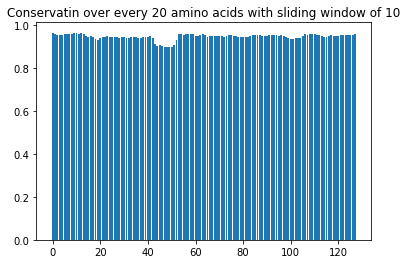

In [40]:
plt.bar(range(len(conservation_smooth)), conservation_smooth)
plt.title(f"Conservatin over every {bin_size} amino acids with sliding window of {sliding}")

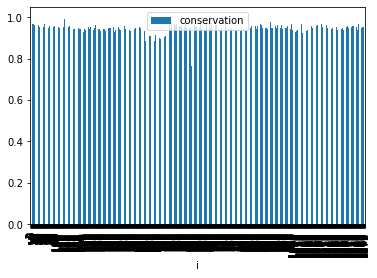

In [8]:
frequencies.plot.bar(x="i", y = "conservation")

### Identities file (_identities.csv)

Contains the sequence identity of each sequence in the alignment to the target sequence. 

*output key: identities_file*

columns:
- id: sequence identifier
- identity_to_query: fraction of sequence identity to the target sequence. 

In [11]:
ids = pd.read_csv(os.path.join(align_prefix + "_identities.csv"))
ids.head()

,id,identity_to_query
0,hCoV_19ChileTalca_22020_EPI_ISL_414578_2020_03_04,1.000
1,hCoV_19ChinaWF00092020_EPI_ISL_413696_2020_01,0.148
2,hCoV_19NetherlandsZuidHolland_232020_EPI_ISL_4...,0.077
3,hCoV_19ChinaWF00172020_EPI_ISL_413747_2020_02,0.268
4,hCoV_19pangolinGuangdong12019_EPI_ISL_410721_2019,0.104


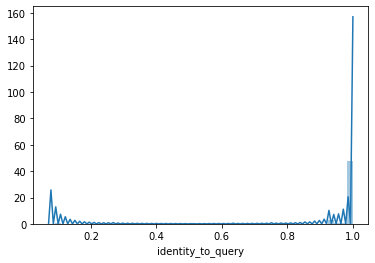

In [12]:
sns.distplot(ids["identity_to_query"])

Text(0.5, 1.0, 'Identity to query (randomly chosen representative)')

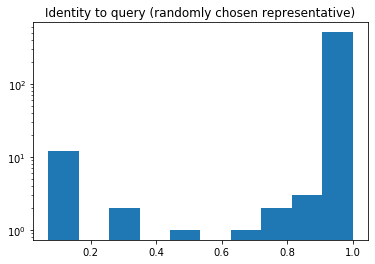

In [43]:
plt.hist(ids["identity_to_query"], log=True)
plt.title("Identity to query (randomly chosen representative)")


## 

------

## Part 2: Coupling scores and comparison to structure

### Raw evolutionary couplings file (_ECs.txt)

### Coupling Scores File (_CouplingScores.csv)

Contains the evolutionary couplings sorted according to score, and the probability that a pair represents significant coupling rather than background noise (probability of belonging to the lognormal component of a lognormal (signal) - skew normal (noise) mixture model).

Note: this file contains couplings between positions that are close on the chain, which are known to be high due to short-range contacts in the molecule. You may want to filter these before further analysis. 

*output key: ec_file*

Columns:
- i: position i, numbered according to target sequence
- A_i: character in position i in target sequence
- Segment_i: (complexes only) specifies whether position i originates from the first monomer (A_1) or the second monomer (B_1). Position i is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- j: position j, numbered according to target sequence
- A_j: character in position j in target sequence
- Segment_j: (complexes only) specifies whether position j originates from the first monomer (A_1) or the second monomer (B_1). Position j is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- fn: placeholder column (formerly fn score)
- cn: Evolutionary couplings score (cn score)
- probability: Probability that this coupling is significant (i.e. in the lognormal signal tail)

In [28]:
scores = pd.read_csv(coupling_prefix +"_CouplingScores.csv")
scores
#scores = pd.concat((scores,scores.copy().rename({"i": "j_"},axis=1).rename({"j":"i"},axis=1).rename({"j_":"j"},axis=1)),axis=0)



,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,416,G,417,K,0,0.005785,A,A,0.999281
1,417,K,419,A,0,0.005581,A,A,0.998514
2,417,K,427,D,0,0.005482,A,A,0.997924
3,410,I,417,K,0,0.005469,A,A,0.997833
4,413,G,417,K,0,0.005393,A,A,0.997223
5,417,K,421,Y,0,0.005393,A,A,0.997223
6,414,Q,417,K,0,0.005391,A,A,0.997205
7,417,K,424,K,0,0.005391,A,A,0.997205
8,1221,I,1243,C,0,0.005160,A,A,0.994302
9,415,T,417,K,0,0.005147,A,A,0.994079


In [29]:
scores.sort_values(["cn"])

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
809627,143,V,556,N,0,-0.002709,A,A,0.000000
809626,799,G,941,T,0,-0.002593,A,A,0.000000
809625,522,A,941,T,0,-0.002593,A,A,0.000000
809624,346,R,707,Y,0,-0.002567,A,A,0.000000
809623,346,R,653,A,0,-0.002556,A,A,0.000000
809622,286,T,553,T,0,-0.002515,A,A,0.000000
809621,286,T,670,I,0,-0.002515,A,A,0.000000
809620,346,R,706,A,0,-0.002497,A,A,0.000000
809608,214,R,558,K,0,-0.002456,A,A,0.000000
809609,368,L,547,T,0,-0.002456,A,A,0.000000


### Cumulative coupling score file (_enrichment.csv)

Measures the how strongly individual residues are coupled by summing the coupling scores of pairs involving this residues, and then normalizing with the average level of coupling (i.e. enrichment of coupling on this residue relative to background). Highly enriched residues may indicate functionally important residues. Uses the top L ECs for calculation by default. 

*output key: enrichment_file*

Columns:
- i: position i
- A_i: character i
- enrichment: Sum of the evolutionary coupling scores that involve this residue, normalized by the background level of coupling

,i,A_i,enrichment
0,1243,C,48.861463
1,1221,I,47.995050
2,212,L,44.959047
3,360,N,36.848481
4,588,T,35.614036
5,542,N,35.451181
6,904,Y,35.415970
7,842,G,33.783361
8,1216,I,28.553730
9,927,F,27.540375


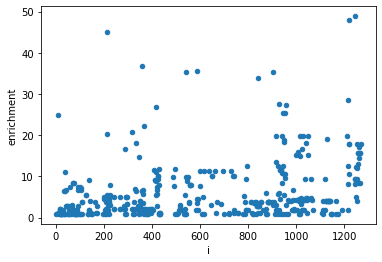

In [18]:
enrich = pd.read_csv(coupling_prefix+"_enrichment.csv")

enrich.plot.scatter(x="i",y="enrichment")
enrich

## Construct contact matrix

In [21]:
from coevolve.couplings.couplings_vis import construct_monomer_contact_matrix


### With cn

In [26]:
construct_monomer_contact_matrix(gene_of_interest, 
                                 input_dir = evc_dir, 
                                 to_plot=True, 
                                 f_save_fig = join(FIGURES_DIR, "contact", gene_of_interest),
                                 f_save = join(contact_dir, gene_of_interest), 
                                 col='cn', conservation=True) 

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8*frequencies.csv


,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
1,0.0,0.001568,0.002307,0.000958,0.002307,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
2,0.0,0.000000,0.001568,-0.000208,0.001568,0.001568,0.001769,-0.000204,0.001562,0.001492,...,-0.000543,0.000435,-0.000543,0.000131,-0.000543,-0.000468,-0.000468,-0.000468,-0.000468,-0.000468
3,0.0,0.000000,0.000000,0.000958,0.002307,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
4,0.0,0.000000,0.000000,0.000000,0.000958,0.000958,0.001059,0.001930,0.000976,0.000018,...,-0.000142,-0.000302,-0.000142,0.000296,-0.000142,-0.000300,-0.000300,-0.000300,-0.000300,-0.000300
5,0.0,0.000000,0.000000,0.000000,0.000000,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001058,0.003200,0.001493,...,-0.000269,-0.000333,-0.000269,0.000384,-0.000269,0.000190,0.000190,0.000190,0.000190,0.000190
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000976,0.000020,...,-0.000145,-0.000302,-0.000145,0.000295,-0.000145,-0.000302,-0.000302,-0.000302,-0.000302,-0.000302
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001360,...,-0.000452,0.000433,-0.000452,0.000097,-0.000452,-0.000083,-0.000083,-0.000083,-0.000083,-0.000083
10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000318,0.000972,-0.000318,0.000164,-0.000318,-0.000317,-0.000317,-0.000317,-0.000317,-0.000317


### with probability 

In [27]:
construct_monomer_contact_matrix(gene_of_interest, 
                                 input_dir = evc_dir, 
                                 to_plot=True, 
                                 f_save_fig = join(FIGURES_DIR, "contact", gene_of_interest+"_pval"),
                                 f_save = join(contact_dir, gene_of_interest+"_pval"), 
                                 col='probability', conservation=True) 

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8*frequencies.csv


,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
1,0.0,0.106677,0.481207,0.000802,0.481207,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.000000,0.106677,0.000000,0.106677,0.106677,0.206065,0.000000,0.104114,7.655791e-02,...,0.000000,1.393567e-10,0.000000,1.519397e-29,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.000000,0.000000,0.000802,0.481207,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,0.000000,0.000000,0.000000,0.000802,0.000802,0.002890,0.294405,0.001029,9.305682e-85,...,0.000000,0.000000e+00,0.000000,1.698589e-15,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,0.0,0.000000,0.000000,0.000000,0.000000,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002857,0.764545,7.691977e-02,...,0.000000,0.000000e+00,0.000000,4.695053e-12,0.000000,1.615808e-22,1.615808e-22,1.615808e-22,1.615808e-22,1.615808e-22
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001029,4.475446e-81,...,0.000000,0.000000e+00,0.000000,1.520697e-15,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.742110e-02,...,0.000000,1.235183e-10,0.000000,5.504890e-36,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,9.739901e-04,0.000000,3.564153e-25,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## TO DO: ADD THE GLYCOSITES

In [7]:
# P03454_glyco = np.array([27,28, 73, 142, 285, 497])
# print(frequencies["A_i"].values[P03454_glyco-1])
# print(frequencies["A_i"].values[P03454_glyco])
# print(frequencies["A_i"].values[P03454_glyco+1])
# print(frequencies["A_i"].values[P03454_glyco+2])

# print("Good as is")
# glycosites = P03454_glyco

# frequencies[frequencies["i"].isin(glycosites)]

['N' 'N' 'N' 'N' 'N' 'N']
['N' 'S' 'I' 'H' 'A' 'G']
['S' 'T' 'T' 'T' 'S' 'T']
['T' 'D' 'G' 'F' 'M' 'Y']
Good as is


## Look at sites adjacent to coupling

## Plot sequences

In [25]:
seqs_msa_a2m = read_msa(os.path.join(align_prefix+".a2m"))

In [26]:
glyco_seqs_msa_a2m = seqs_msa_a2m[:,glycosites-1]
adj_seqs_msa_a2m = seqs_msa_a2m[:,np.array(list(adj_sites))-1] 

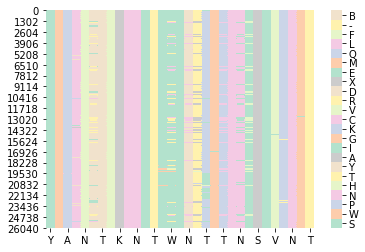

In [27]:
value_to_int = {j:i for i,j in enumerate(pd.unique(adj_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(adj_seqs_msa_a2m, 
                              columns=frequencies[frequencies["i"].isin(adj_sites)]["A_i"].values).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.show()

## Pairwise matrix where just the differences are plotted and then n for how many times is written

/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'I'): 23885, ('N', 'V'): 2549, ('N', 'I'): 141, ('K', 'V'): 624, ('K', 'M'): 3, ('E', 'I'): 21, ('R', 'I'): 40, ('K', 'T'): 10, ('K', 'N'): 1, ('S', 'V'): 20, ('I', 'I'): 6, ('G', 'V'): 1, ('R', 'V'): 2, ('K', 'X'): 1, ('E', 'V'): 1, ('X', 'I'): 3, ('T', 'I'): 1, ('D', 'V'): 13, ('K', 'L'): 4, ('Y', 'F'): 1, ('N', 'A'): 1, ('N', 'L'): 3, ('X', 'X'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('T', 'N'): 1114, ('I', 'D'): 23436, ('N', 'N'): 1139, ('T', 'D'): 711, ('I', 'N'): 78, ('S', 'N'): 2, ('R', 'D'): 90, ('N', 'D'): 7, ('V', 'D'): 241, ('X', 'D'): 4, ('I', 'G'): 8, ('I', 'E'): 88, ('N', 'K'): 1, ('F', 'D'): 1, ('T', 'K'): 4, ('X', 'X'): 3, ('M', 'D'): 368, ('T', 'T'): 1, ('S', 'D'): 1, ('L', 'D'): 8, ('K', 'D'): 13, ('V', 'N'): 6, ('M', 'N'): 2, ('T', 'S'): 3, ('I', 'K'): 1, ('N', 'S'): 1, ('T', 'E'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('T', 'A'): 2078, ('N', 'A'): 185, ('D', 'T'): 22415, ('E', 'T'): 695, ('D', 'A'): 671, ('E', 'A'): 997, ('N', 'T'): 37, ('X', 'T'): 38, ('S', 'V'): 1, ('T', 'V'): 2, ('D', 'I'): 20, ('D', 'K'): 46, ('D', 'V'): 37, ('-', 'A'): 3, ('E', 'V'): 32, ('X', 'A'): 3, ('I', 'A'): 1, ('T', 'T'): 4, ('S', 'A'): 8, ('D', 'S'): 9, ('E', 'X'): 2, ('D', 'X'): 4, ('D', 'M'): 1, ('E', 'I'): 17, ('E', 'K'): 7, ('E', 'E'): 1, ('D', 'E'): 1, ('D', 'R'): 3, ('K', 'A'): 4, ('E', 'R'): 7, ('Y', 'A'): 1, ('G', 'T'): 1, ('B', 'T'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'I'): 24413, ('K', 'V'): 63, ('N', 'I'): 2157, ('K', 'F'): 25, ('E', 'I'): 22, ('R', 'I'): 42, ('N', 'M'): 526, ('S', 'I'): 6, ('K', 'M'): 19, ('K', 'X'): 4, ('K', 'L'): 3, ('I', 'I'): 6, ('G', 'I'): 1, ('N', 'V'): 6, ('X', 'I'): 4, ('T', 'I'): 1, ('S', 'M'): 14, ('D', 'I'): 3, ('D', 'M'): 10, ('N', 'L'): 4, ('Y', 'I'): 1, ('N', 'S'): 1, ('K', 'K'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'T'): 896, ('K', 'I'): 23435, ('N', 'T'): 931, ('N', 'N'): 1145, ('N', 'I'): 102, ('E', 'I'): 21, ('R', 'I'): 36, ('N', 'S'): 2, ('N', 'R'): 90, ('K', 'V'): 174, ('K', 'X'): 6, ('S', 'T'): 3, ('I', 'I'): 6, ('S', 'N'): 1, ('G', 'T'): 1, ('R', 'T'): 1, ('E', 'T'): 1, ('K', 'F'): 1, ('K', 'N'): 2, ('N', 'M'): 348, ('K', 'S'): 1, ('X', 'I'): 3, ('T', 'I'): 1, ('K', 'M'): 10, ('K', 'L'): 3, ('N', 'K'): 13, ('S', 'I'): 6, ('N', 'X'): 1, ('N', 'V'): 58, ('N', 'L'): 4, ('R', 'V'): 5, ('D', 'M'): 3, ('S', 'V'): 1, ('S', 'M'): 9, ('D', 'V'): 9, ('D', 'L'): 1, ('Y', 'I'): 1, ('X', 'T'): 1})


,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
233,71,K,74,I,0,0.003754,A,A,0.999984
235,283,T,285,N,0,0.003743,A,A,0.999983
397,144,T,286,A,0,0.003262,A,A,0.999591
885,71,K,282,I,0,0.002546,A,A,0.975429
1362,71,K,283,T,0,0.002166,A,A,0.845408


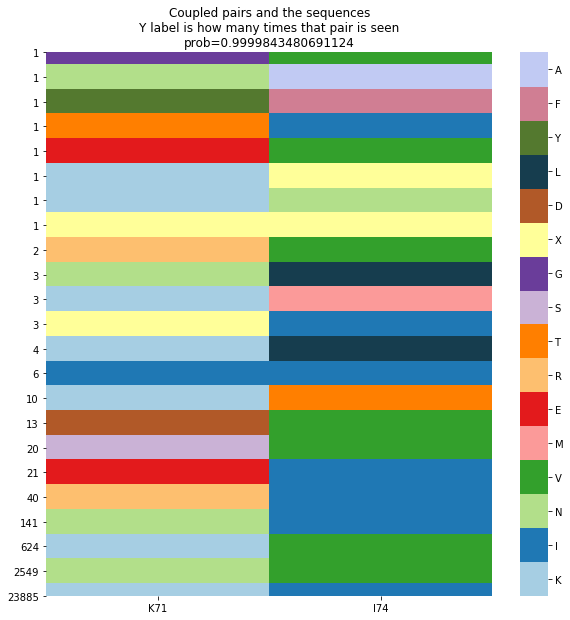

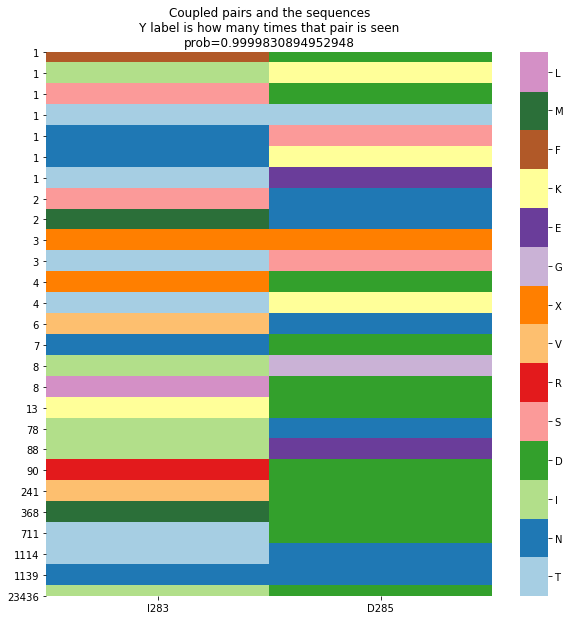

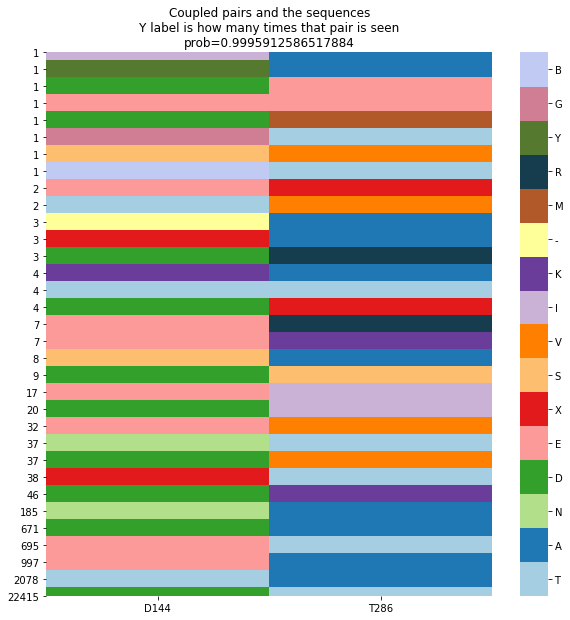

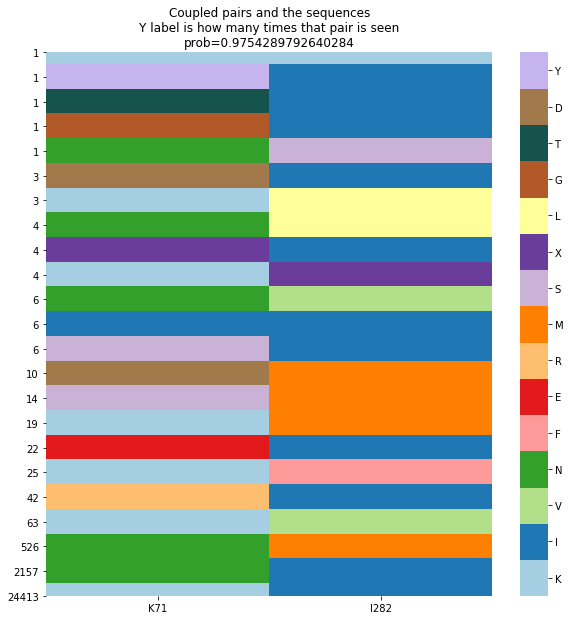

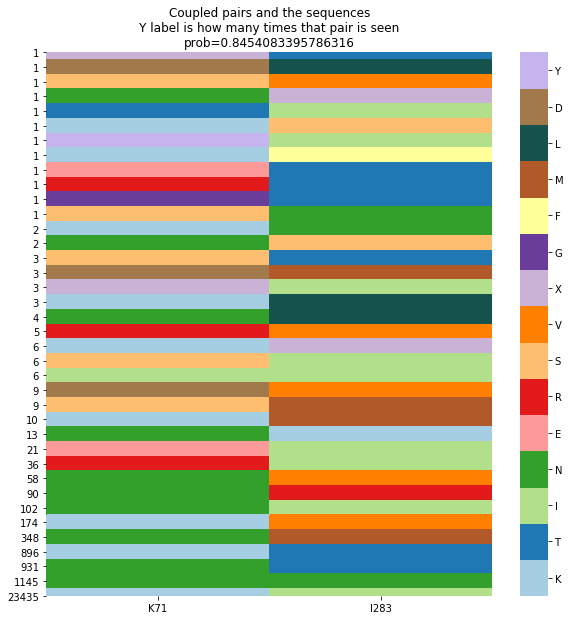

In [30]:
df = scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites)) &
            (scores["probability"]>0.7)]


#def pair_conservation_heat(df):
for ind, val in df.iterrows():
    curr_seqs = seqs_msa_a2m[:,[val["i"]-1, val["j"]-1]]
    
    value_to_int = {j:i for i,j in enumerate(pd.unique(curr_seqs.ravel()))} # like you did
    n = len(value_to_int)
    # discrete colormap (n samples from a given cmap)
    if n > 12:
        cmap = sns.color_palette("Paired", 12) + sns.color_palette("cubehelix", n-12)
    else:
        #cmap = sns.color_palette("Pastel2", n)
        cmap = sns.color_palette("Paired", n)

    d = defaultdict(int)
    for i in curr_seqs:
        d[tuple(i)] += 1
        
    i_max = frequencies[frequencies["i"] == val["i"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()
    j_max = frequencies[frequencies["i"] == val["j"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()  

    curr_df = pd.DataFrame(d.keys(), index=d.values(), columns=(i_max + str(val["i"]), j_max
                                                                + str(val["j"])))
    print(d)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    sns.heatmap(curr_df.replace(value_to_int).sort_index(), cmap=cmap,ax=ax, yticklabels=True ) 
    #plt.xticks(rotation='vertical')
    ax.tick_params(axis='y',which='major', labelrotation=0)
    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))       
    plt.title(f"Coupled pairs and the sequences\nY label is how many times that pair is seen\nprob={val['probability']}")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".png")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".pdf")
    #break
df


In [262]:
not_conserved = []
frequencies["Most_Abundant"] = ""
for ind,val in frequencies.iterrows():
    seq = val["A_i"]
    conserved =  val.drop(["i","A_i","conservation","-","Most_Abundant"]).astype(float).idxmax()
    print("Sequence val: ", seq)
    print("Most conserved:",conserved )
    if not seq == conserved:
        not_conserved.append((ind,seq,conserved))
    frequencies.at[ind,"Most_Abundant"] = conserved
not_conserved

Sequence val:  M
Most conserved: M
Sequence val:  K
Most conserved: K
Sequence val:  A
Most conserved: A
Sequence val:  K
Most conserved: I
Sequence val:  L
Most conserved: L
Sequence val:  L
Most conserved: V
Sequence val:  V
Most conserved: V
Sequence val:  L
Most conserved: L
Sequence val:  L
Most conserved: L
Sequence val:  Y
Most conserved: Y
Sequence val:  A
Most conserved: T
Sequence val:  F
Most conserved: F
Sequence val:  V
Most conserved: T
Sequence val:  A
Most conserved: T
Sequence val:  T
Most conserved: A
Sequence val:  D
Most conserved: N
Sequence val:  A
Most conserved: A
Sequence val:  D
Most conserved: D
Sequence val:  T
Most conserved: T
Sequence val:  I
Most conserved: L
Sequence val:  C
Most conserved: C
Sequence val:  I
Most conserved: I
Sequence val:  G
Most conserved: G
Sequence val:  Y
Most conserved: Y
Sequence val:  H
Most conserved: H
Sequence val:  A
Most conserved: A
Sequence val:  N
Most conserved: N
Sequence val:  N
Most conserved: N
Sequence val:  S
Mos

Sequence val:  T
Most conserved: T
Sequence val:  G
Most conserved: G
Sequence val:  L
Most conserved: L
Sequence val:  R
Most conserved: R
Sequence val:  N
Most conserved: N
Sequence val:  I
Most conserved: V
Sequence val:  P
Most conserved: P
Sequence val:  S
Most conserved: S
Sequence val:  I
Most conserved: I
Sequence val:  Q
Most conserved: Q
Sequence val:  Y
Most conserved: S
Sequence val:  R
Most conserved: R
Sequence val:  G
Most conserved: G
Sequence val:  L
Most conserved: L
Sequence val:  F
Most conserved: F
Sequence val:  G
Most conserved: G
Sequence val:  A
Most conserved: A
Sequence val:  I
Most conserved: I
Sequence val:  A
Most conserved: A
Sequence val:  G
Most conserved: G
Sequence val:  F
Most conserved: F
Sequence val:  I
Most conserved: I
Sequence val:  E
Most conserved: E
Sequence val:  G
Most conserved: G
Sequence val:  G
Most conserved: G
Sequence val:  W
Most conserved: W
Sequence val:  T
Most conserved: T
Sequence val:  G
Most conserved: G
Sequence val:  M
Mos

[(3, 'K', 'I'),
 (5, 'L', 'V'),
 (10, 'A', 'T'),
 (12, 'V', 'T'),
 (13, 'A', 'T'),
 (14, 'T', 'A'),
 (15, 'D', 'N'),
 (19, 'I', 'L'),
 (35, 'I', 'V'),
 (36, 'F', 'L'),
 (41, 'A', 'T'),
 (52, 'R', 'K'),
 (61, 'K', 'R'),
 (63, 'I', 'V'),
 (67, 'Q', 'H'),
 (74, 'T', 'A'),
 (77, 'L', 'I'),
 (84, 'D', 'E'),
 (87, 'L', 'S'),
 (88, 'P', 'T'),
 (90, 'R', 'S'),
 (99, 'P', 'S'),
 (102, 'E', 'D'),
 (105, 'A', 'T'),
 (113, 'D', 'N'),
 (127, 'L', 'F'),
 (136, 'E', 'T'),
 (143, 'T', 'D'),
 (144, 'F', 'N'),
 (145, 'N', 'K'),
 (149, 'V', 'A'),
 (150, 'S', 'A'),
 (152, 'S', 'P'),
 (154, 'R', 'A'),
 (156, 'K', 'A'),
 (157, 'S', 'K'),
 (161, 'R', 'K'),
 (164, 'L', 'I'),
 (167, 'T', 'V'),
 (171, 'D', 'N'),
 (177, 'T', 'S'),
 (178, 'N', 'K'),
 (181, 'V', 'I'),
 (183, 'N', 'D'),
 (194, 'V', 'I'),
 (199, 'S', 'T'),
 (201, 'D', 'A'),
 (202, 'E', 'D'),
 (208, 'S', 'Q'),
 (210, 'G', 'A'),
 (211, 'N', 'D'),
 (215, 'S', 'F'),
 (217, 'A', 'G'),
 (218, 'S', 'T'),
 (220, 'N', 'R'),
 (222, 'N', 'S'),
 (223, 'R', 'K')

In [265]:
frequencies[(frequencies["Most_Abundant"] == "N")]

,i,A_i,conservation,-,A,C,D,E,F,G,...,N,P,Q,R,S,T,V,W,Y,Most_Abundant
15,16,D,0.811,0.000,0.0,0.0,0.015,0.0,0.0,0.000,...,0.856,0.0,0.0,0.0,0.004,0.001,0.0,0.0,0.077,N
26,27,N,0.998,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.999,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N
27,28,N,0.999,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,1.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N
39,40,N,0.998,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.999,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N
47,48,N,0.988,0.000,0.0,0.0,0.005,0.0,0.0,0.000,...,0.995,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N
54,55,N,0.983,0.000,0.0,0.0,0.006,0.0,0.0,0.000,...,0.992,0.0,0.0,0.0,0.001,0.000,0.0,0.0,0.000,N
72,73,N,0.892,0.000,0.0,0.0,0.002,0.0,0.0,0.000,...,0.906,0.0,0.0,0.0,0.091,0.000,0.0,0.0,0.000,N
80,81,N,0.999,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,1.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N
100,101,N,0.735,0.000,0.0,0.0,0.002,0.0,0.0,0.006,...,0.507,0.0,0.0,0.0,0.473,0.001,0.0,0.0,0.000,N
103,104,N,0.981,0.000,0.0,0.0,0.004,0.0,0.0,0.000,...,0.991,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,N


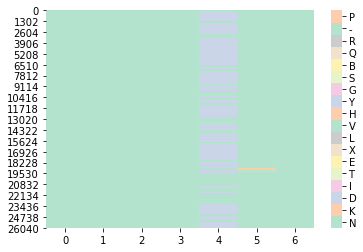

In [44]:
value_to_int = {j:i for i,j in enumerate(pd.unique(glyco_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(glyco_seqs_msa_a2m).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.show()